In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#data_url = 'http://www.ndbc.noaa.gov/data/5day2/46022_5day.txt'
data_url = 'http://www.ndbc.noaa.gov/data/realtime2/46022.txt'

# Set the number of hours to report.
LAST_HOURS = 24
buoy22_df = pd.read_csv(data_url, header=0, skiprows=[1], nrows=LAST_HOURS, sep='\s+', na_values=['MM', -99])
buoy22_df.head()

,#YY,MM,DD,hh,mm,WDIR,WSPD,GST,WVHT,DPD,APD,MWD,PRES,ATMP,WTMP,DEWP,VIS,PTDY,TIDE
0,2016,12,7,18,50,120,8.0,9.0,2.3,11,7.6,316,1018.4,9.3,12.5,2.9,NaN,-0.5,NaN
1,2016,12,7,17,50,120,7.0,8.0,2.3,11,7.9,311,1018.8,9.6,12.5,2.1,NaN,-0.5,NaN
2,2016,12,7,16,50,120,6.0,8.0,2.2,11,7.9,313,1019.1,9.1,12.5,2.5,NaN,-0.6,NaN
3,2016,12,7,15,50,100,8.0,10.0,2.3,12,8.2,322,1018.9,7.8,12.5,3.6,NaN,-1.2,NaN
4,2016,12,7,14,50,100,8.0,10.0,2.0,11,7.3,322,1019.3,7.0,12.4,2.6,NaN,-1.0,NaN


In [3]:
# Change column names for use with datetime.
last_24 = buoy22_df[['#YY', 'MM', 'DD', 'hh', 'mm']]
last_24.columns = ['year', 'month', 'day', 'hour', 'minute']
last_24.head()

,year,month,day,hour,minute
0,2016,12,7,18,50
1,2016,12,7,17,50
2,2016,12,7,16,50
3,2016,12,7,15,50
4,2016,12,7,14,50


In [4]:
# Convert times to PST
ts = pd.to_datetime(last_24, utc=True)
last_hour = ts[0] - pd.DateOffset(hours=7)
first_hour = last_hour - pd.DateOffset(hours=LAST_HOURS)

# Create title string
tlt_str = 'Observations from ' + str(last_hour) + ' to ' + str(first_hour)
[ts.head(), tlt_str]

[0   2016-12-07 18:50:00
 1   2016-12-07 17:50:00
 2   2016-12-07 16:50:00
 3   2016-12-07 15:50:00
 4   2016-12-07 14:50:00
 dtype: datetime64[ns],
 'Observations from 2016-12-07 11:50:00 to 2016-12-06 11:50:00']

In [13]:
MWD_df = buoy22_df[['DPD', 'MWD']].copy()
MWD_df['WHT'] = buoy22_df.apply(lambda x: np.around(x['WVHT'] * 3.4, decimals=1), axis=1)
MWD_df.index = ts
MWD_df.head()

,DPD,MWD,WHT
2016-12-07 18:50:00,11,316,7.8
2016-12-07 17:50:00,11,311,7.8
2016-12-07 16:50:00,11,313,7.5
2016-12-07 15:50:00,12,322,7.8
2016-12-07 14:50:00,11,322,6.8


In [6]:
# Get pertinent information from buoy22_df and convert meters to feet.
# Change time order to oldest on top.
MWD_df = buoy22_df[['DPD', 'MWD']]
MWD_df.index = ts
feet = np.around(buoy22_df.loc[:,'WVHT'] * 3.4, decimals=1).values
MWD_df.insert(0, 'WVHT', feet)

MWD_df = MWD_df.sort_index(ascending=True, axis=0)
MWD_df = MWD_df.reset_index()
my_cols = ['data']
MWD_df.columns = ['date', 'WVHT', 'DPD', 'MWD']
MWD_df.hea

,date,WVHT,DPD,MWD
0,2016-12-06 19:50:00,10.5,13,341
1,2016-12-06 20:50:00,11.6,14,333
2,2016-12-06 21:50:00,11.9,14,344
3,2016-12-06 22:50:00,12.2,12,323
4,2016-12-06 23:50:00,11.9,12,333
5,2016-12-07 00:50:00,12.9,14,336
6,2016-12-07 01:50:00,12.2,14,340
7,2016-12-07 02:50:00,12.6,13,336
8,2016-12-07 03:50:00,14.3,12,331
9,2016-12-07 04:50:00,13.6,14,329


In [7]:
MWD_df.describe()

,WVHT,DPD,MWD
count,24.000000,24.000000,24.000000
mean,10.641667,12.541667,323.875000
std,2.168734,1.102533,10.489384
min,6.800000,11.000000,309.000000
25%,9.025000,12.000000,315.750000
50%,11.600000,12.500000,321.500000
75%,12.200000,13.250000,333.000000
max,14.300000,14.000000,344.000000


In [8]:
# Get data for plotting
# Convert swell direction from degrees to radians
theta = np.deg2rad(MWD_df[['MWD']])
period = MWD_df[['DPD']]

# Times are indexed with ints starting at 2 so that MWD can be detected.
r = np.arange(len(theta) + 1,  1, -1)

# Get info for title string
# Max and min hights will be reported in feet
height_min = MWD_df[['WVHT']].min().values
height_max = MWD_df[['WVHT']].max().values
hts_str =  str(height_min) + '\' to ' + str(height_max) + '\''

# Get most current time reported and convert it from 'UTC' to 'PDT'
date_str = str(MWD_df.date.max() - pd.DateOffset(hours=7))
tlt_str = 'Buoy 22 Last 24 Hours ' + '\n' + date_str + '\n Hts ' + hts_str

# Get most current data
latest_wht = str(float(MWD_df[['WVHT']].iloc[-1].values))
latest_dpd = str(float(MWD_df[['DPD']].iloc[-1].values))
latest_mwd = str(float(MWD_df[['MWD']].iloc[-1].values))
latest_str = date_str + '\n' + latest_wht + ' ft @ ' + latest_dpd + ' sec' + '\n' + 'Direction: ' + latest_mwd 

# Scale point sizes based on max and min wave height
SMALL_PNT_SZ = 20
LARGE_PNT_SZ = 200
diff = LARGE_PNT_SZ - SMALL_PNT_SZ
m = np.divide(diff, height_max - height_min)
b = (SMALL_PNT_SZ * height_max - LARGE_PNT_SZ * height_min) / (height_max - height_min)

pnt_sz = m*MWD_df[['WVHT']] + b
type(theta)

pandas.core.frame.DataFrame

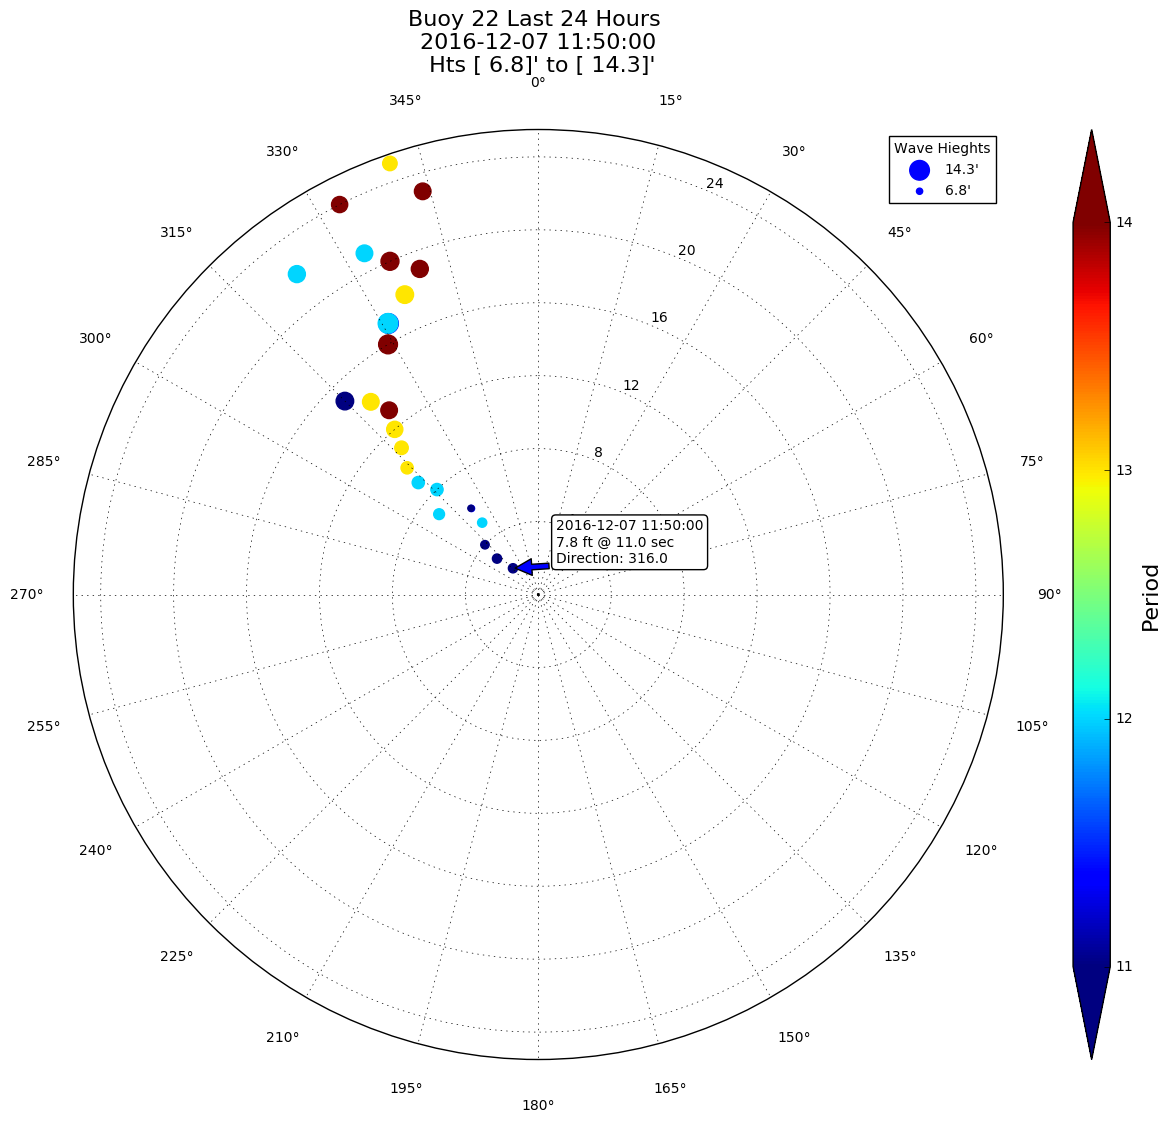

In [9]:
my_plot = plt.rcParams['figure.figsize'] =[18, 12]

ax = plt.subplot(111, projection='polar')
ax.set_theta_direction(-1)
ax.set_theta_offset(np.pi/2)
theta_tics = np.arange(0, 360, 15)
ax.set_thetagrids(theta_tics)
ax.set_rlim([0, 25.5])
r_tics = np.arange(4, 28, 4)
ax.set_rgrids(r_tics)
ax.grid(True)

big_idx = pnt_sz.idxmax()
small_idx = pnt_sz.idxmin()

big_str = str(float(MWD_df.iloc[big_idx]['WVHT'])) + "'"
small_str = str(float(MWD_df.iloc[small_idx]['WVHT'])) + "'"

#### These two plots are still visable after plotting the main plot. ####
big = ax.scatter(theta.iloc[big_idx], r[int(big_idx)], s=pnt_sz.iloc[big_idx], edgecolors='face')
small = ax.scatter(theta.iloc[small_idx], r[int(small_idx)], s=pnt_sz.iloc[small_idx], edgecolors='face')

p = ax.scatter(theta, r, s=pnt_sz, c=period, edgecolors='face')

cbar = plt.colorbar(p, extend='both', extendfrac=0.125)
cbar.set_label('Period', fontsize=16)
cbar.set_ticks(np.arange(period.min(), period.max() + 1))

ax.set_title(tlt_str, va='bottom', fontsize=16)

thistheta = theta.iloc[-1]
thisr = r[-1]
ax.annotate(latest_str,
            xy=(thistheta, thisr),  # theta, radius
            xytext=(0.5, 2),    # fraction, fraction
            bbox=dict(boxstyle="round", fc="w"),
            arrowprops=dict(facecolor='blue', shrink=0.05)
            )

# Plot legend.
lgnd = plt.legend([big_str, small_str], loc="upper right", scatterpoints=1, fontsize=10, title='Wave Hieghts')

plt.show(ax)